In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls.csv")

In [3]:
df = pd.read_csv("../Data/raw/president_polls.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [5]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [6]:
df['date'] = df.median_date
#df['date'] = df.end_date
#df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [7]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [8]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Kamala Harris'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'
df_2way = df_2way[df_2way['date'] >= '2024-07-21'] 

#df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [9]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_jb = df_polls.merge(df_count)
df_2way_jb = df_2way_jb.rename(columns={'REP':'GOP'})
df_2way_jb['type'] = '2way'
df_2way_jb = df_2way_jb[df_2way_jb['date'] < '2024-07-21'] 

#df_2way_jb['sample_size'] = round(df_2way_jb['sample_size'] * (df_2way_jb['DEM'] + df_2way_jb['GOP'])/100)
df_2way_jb[['DEM', 'GOP']] = df_2way_jb[['DEM', 'GOP']].div(100)

In [10]:
df = pd.concat([df_2way, df_2way_jb])
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

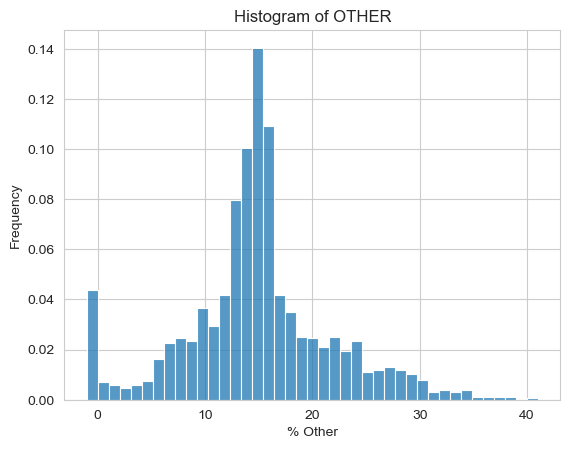

In [11]:
bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Histogram of OTHER')
plt.show()

In [12]:
df = df.query("OTHER > 0")

In [13]:
df.head(20)

,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,election_date,date,year,month,day,week,DEM,GOP,type,obs_id,OTHER
0,87721,205625,1424,Siena/NYT,Live Phone,PA,rv,693.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.490,0.460,2way,0,0.050
1,87721,205628,1424,Siena/NYT,Live Phone,PA,lv,693.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.500,0.460,2way,1,0.040
2,87721,205631,1424,Siena/NYT,Live Phone,PA,rv,693.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.450,0.430,2way,2,0.120
3,87721,205634,1424,Siena/NYT,Live Phone,PA,lv,693.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.460,0.440,2way,3,0.100
4,87722,205641,1886,Quantus Polls and News,Online Panel,US,rv,1000.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.472,0.459,2way,4,0.069
5,87719,205623,1424,Siena/NYT,Live Phone,MI,rv,619.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.450,0.480,2way,5,0.070
6,87719,205626,1424,Siena/NYT,Live Phone,MI,lv,619.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.500,0.460,2way,6,0.040
7,87719,205629,1424,Siena/NYT,Live Phone,MI,rv,619.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.440,0.430,2way,7,0.130
8,87719,205632,1424,Siena/NYT,Live Phone,MI,lv,619.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.480,0.430,2way,8,0.090
9,87720,205624,1424,Siena/NYT,Live Phone,WI,rv,661.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.500,0.460,2way,9,0.040


Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [14]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,191.000000,191.000000
mean,0.458445,0.452471
std,0.033927,0.034879
min,0.370000,0.340000
25%,0.440000,0.430000
50%,0.460000,0.450000
75%,0.483500,0.470000
max,0.540000,0.575000


In [15]:
df_2way_jb[['DEM', 'GOP']].describe()

,DEM,GOP
count,3016.000000,3016.000000
mean,0.418071,0.433630
std,0.048901,0.047317
min,0.148000,0.210000
25%,0.390000,0.410000
50%,0.420000,0.430000
75%,0.440000,0.460000
max,0.680000,0.676000


In [16]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

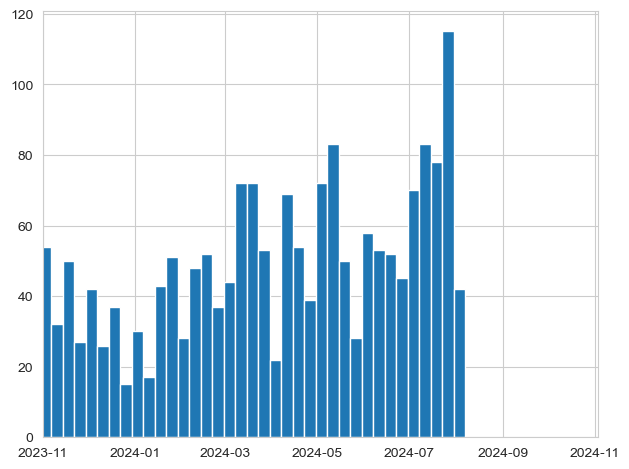

In [17]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 1), dt.datetime(2024, 11, 3))

plt.tight_layout()
plt.show()

In [18]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Live Phone/Text-to-Web,Probability Panel,IVR/Online Panel,IVR/Online Panel/Text-to-Web,Online Panel/Text-to-Web,Online Panel/Text-to-Web/Text,IVR/Text-to-Web,Live Phone/Online Panel
pollster,,,,,,,,,,,
All,3059,1652,311,144,132,130,85,67,51,51,50
Morning Consult,746,746,0,0,0,0,0,0,0,0,0
Emerson,238,0,0,0,0,48,79,3,0,2,0
YouGov,191,191,0,0,0,0,0,0,0,0,0
Redfield & Wilton Strategies,179,179,0,0,0,0,0,0,0,0,0
Echelon Insights,103,96,0,7,0,0,0,0,0,0,0
Siena/NYT,94,0,94,0,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,92,0,0,0,0,52,0,0,0,34,0
Ipsos,76,0,0,0,76,0,0,0,0,0,0


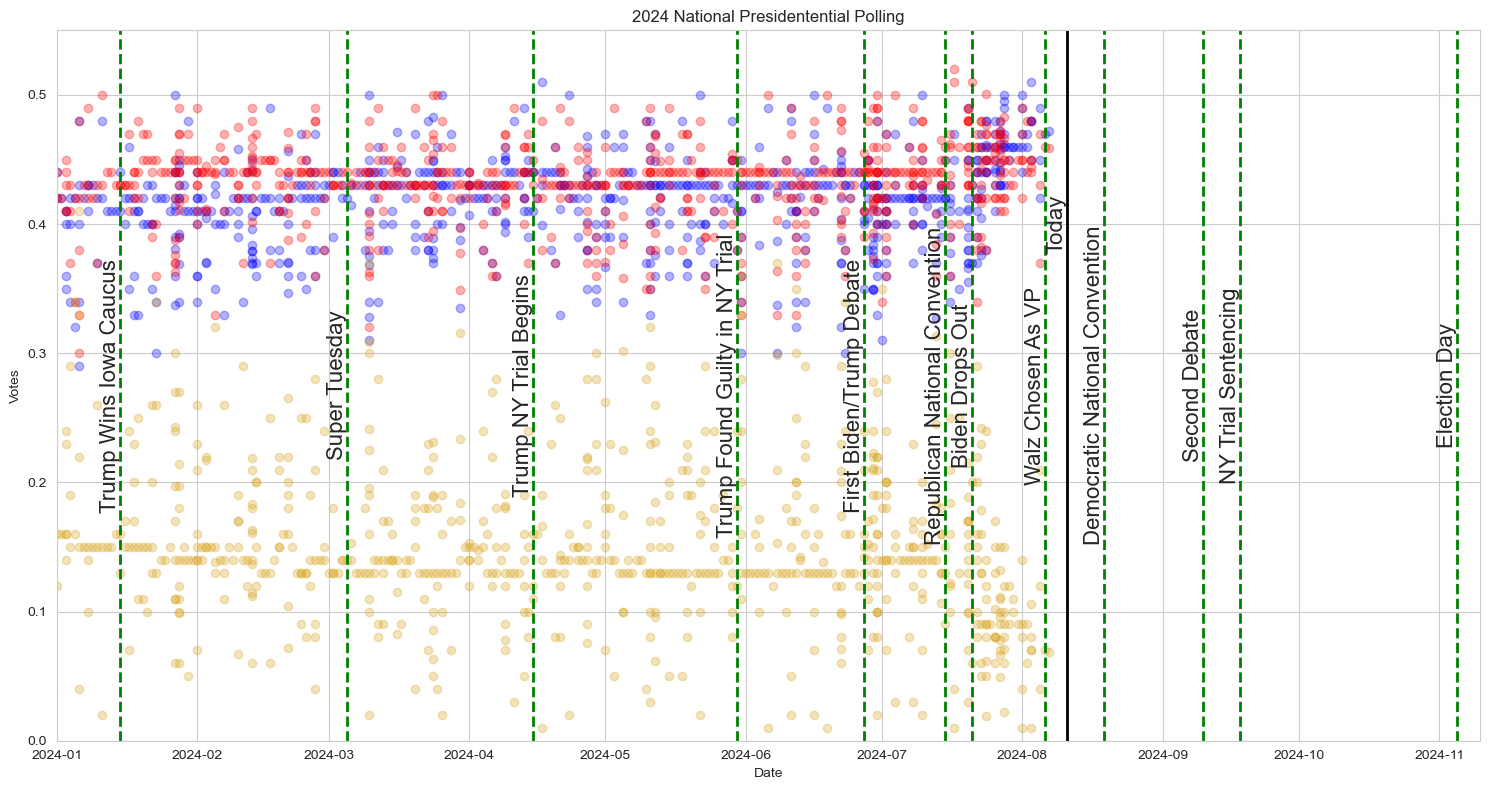

In [19]:
dem_votes = df.query("state == 'US'")["DEM"].values
gop_votes = df.query("state == 'US'")["GOP"].values
oth_votes = df.query("state == 'US'")["OTHER"].values

dates = df.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.3, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5),  'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.275, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.4, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

In [20]:
df.head(20).tail(10)

,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,election_date,date,year,month,day,week,DEM,GOP,type,obs_id,OTHER
10,87720,205627,1424,Siena/NYT,Live Phone,WI,lv,661.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.50,0.460,2way,10,0.040
11,87720,205630,1424,Siena/NYT,Live Phone,WI,rv,661.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.49,0.420,2way,11,0.090
12,87720,205633,1424,Siena/NYT,Live Phone,WI,lv,661.0,2024,11/5/24,2024-08-07,2024,8,-90,-13,0.49,0.430,2way,12,0.080
13,87710,205594,1554,RMG Research,Online Panel,US,rv,2000.0,2024,11/5/24,2024-08-06,2024,8,-91,-13,0.47,0.460,2way,13,0.070
14,87709,205592,241,Ipsos,Probability Panel,US,rv,1342.0,2024,11/5/24,2024-08-05,2024,8,-92,-14,0.42,0.370,2way,14,0.210
15,87709,205593,241,Ipsos,Probability Panel,US,rv,1342.0,2024,11/5/24,2024-08-05,2024,8,-92,-14,0.49,0.470,2way,15,0.040
17,87700,205438,1102,Emerson,Online Panel/Text-to-Web,MT,lv,1000.0,2024,11/5/24,2024-08-05,2024,8,-92,-14,0.39,0.535,2way,17,0.075
18,87696,205407,568,YouGov,Online Panel,US,rv,1413.0,2024,11/5/24,2024-08-05,2024,8,-92,-14,0.45,0.430,2way,18,0.120
20,87694,205342,1741,ActiVote,App Panel,US,lv,1000.0,2024,11/5/24,2024-08-03,2024,8,-94,-14,0.45,0.444,2way,20,0.106
21,87677,205228,460,SurveyUSA,Online Panel,US,lv,1510.0,2024,11/5/24,2024-08-03,2024,8,-94,-14,0.48,0.450,2way,21,0.070


Text(0.5, 1.0, '30-Day Rolling National Polling Standard Deviation')

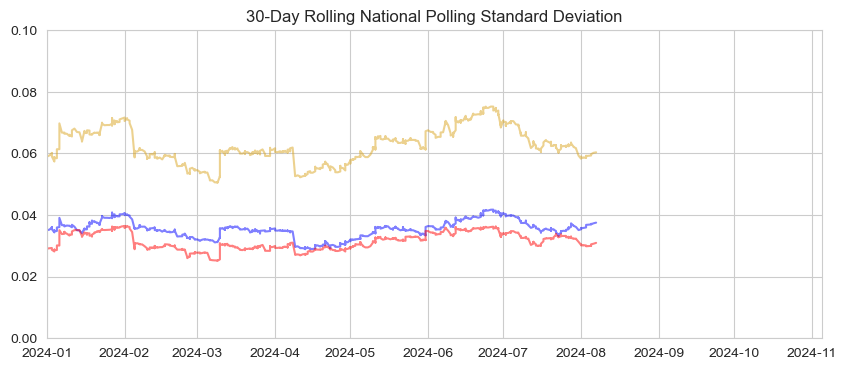

In [21]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .1)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("30-Day Rolling National Polling Standard Deviation")

Text(0.5, 1.0, '7-Day Rolling National Polling Mean')

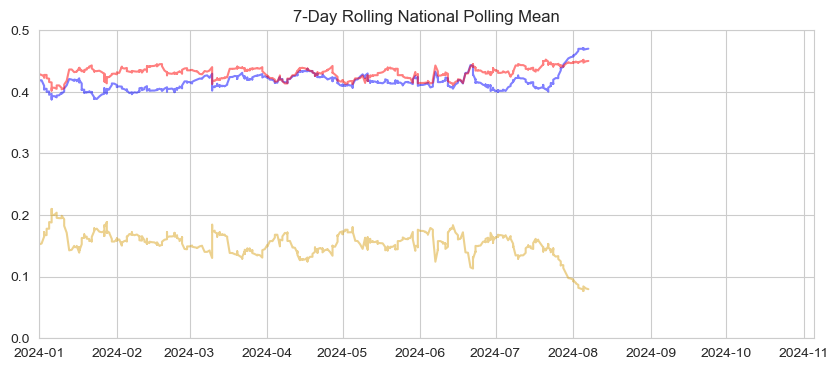

In [22]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .5)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Standard Deviation')

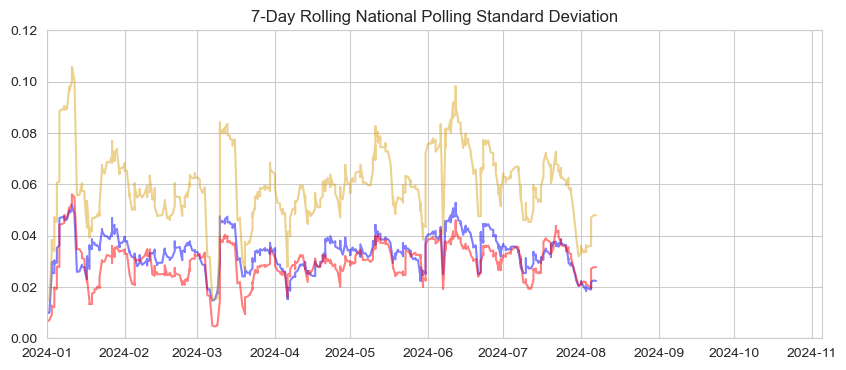

In [23]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .12)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Standard Deviation")

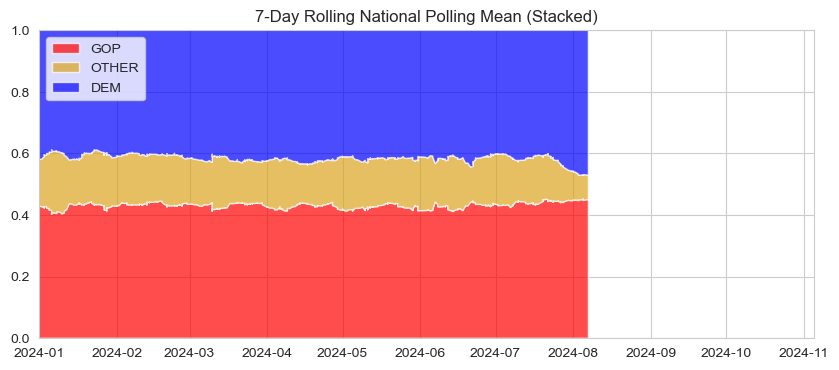

In [24]:
rolling_mean = (
    df.query("state == 'US'")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

We can see here that polling methodology is irrelevant, they all perform about the same.

In [25]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.409333,0.444088
IVR/Text,0.475000,0.450000
Live Phone,0.427317,0.434342
Live Phone/Online Panel,0.456000,0.440000
Online Panel,0.420703,0.423308
Probability Panel,0.390171,0.390427
Text-to-Web/Online Ad,0.397500,0.425000


We can see that Trump fairly consistently out-performs on App Panel polls.

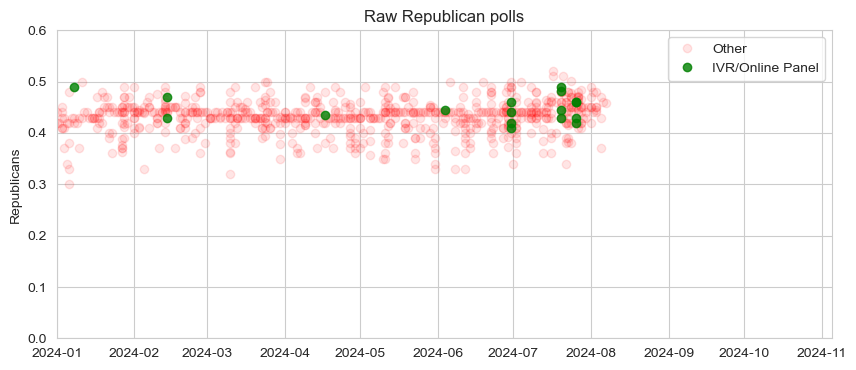

In [26]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [27]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [28]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,87721,205625,1424,Siena/NYT,Live Phone,PA,rv,693.0,2024,...,2way,0,0.05,0.03,0.45,0.48,0.03,0.01,0.01,0.00
1,1,87721,205628,1424,Siena/NYT,Live Phone,PA,lv,693.0,2024,...,2way,1,0.04,0.04,0.45,0.48,0.03,0.01,0.02,0.01
2,2,87721,205631,1424,Siena/NYT,Live Phone,PA,rv,693.0,2024,...,2way,2,0.12,0.02,0.45,0.48,0.03,-0.02,-0.03,-0.01
3,3,87721,205634,1424,Siena/NYT,Live Phone,PA,lv,693.0,2024,...,2way,3,0.10,0.02,0.45,0.48,0.03,-0.01,-0.02,-0.01
4,4,87722,205641,1886,Quantus Polls and News,Online Panel,US,rv,1000.0,2024,...,2way,4,0.07,0.01,0.45,0.48,0.03,0.01,-0.01,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,3013,74810,142358,568,YouGov,Online Panel,US,a,1561.0,2024,...,2way,3202,0.16,0.12,0.36,0.48,0.12,0.00,0.00,0.00
3055,3014,74928,142758,446,St. Anselm,Text-to-Web,NH,rv,1267.0,2024,...,2way,3203,0.06,0.08,0.43,0.51,0.08,0.00,0.00,0.00
3056,3015,74706,140769,1056,Remington,IVR,MO,lv,933.0,2024,...,2way,3204,0.09,-0.15,0.53,0.38,-0.15,0.00,0.00,0.00
3057,3016,74812,142390,241,Ipsos,Probability Panel,US,a,1105.0,2024,...,2way,3205,0.27,0.17,0.28,0.45,0.17,0.00,0.00,0.00


In [29]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,-0.014118


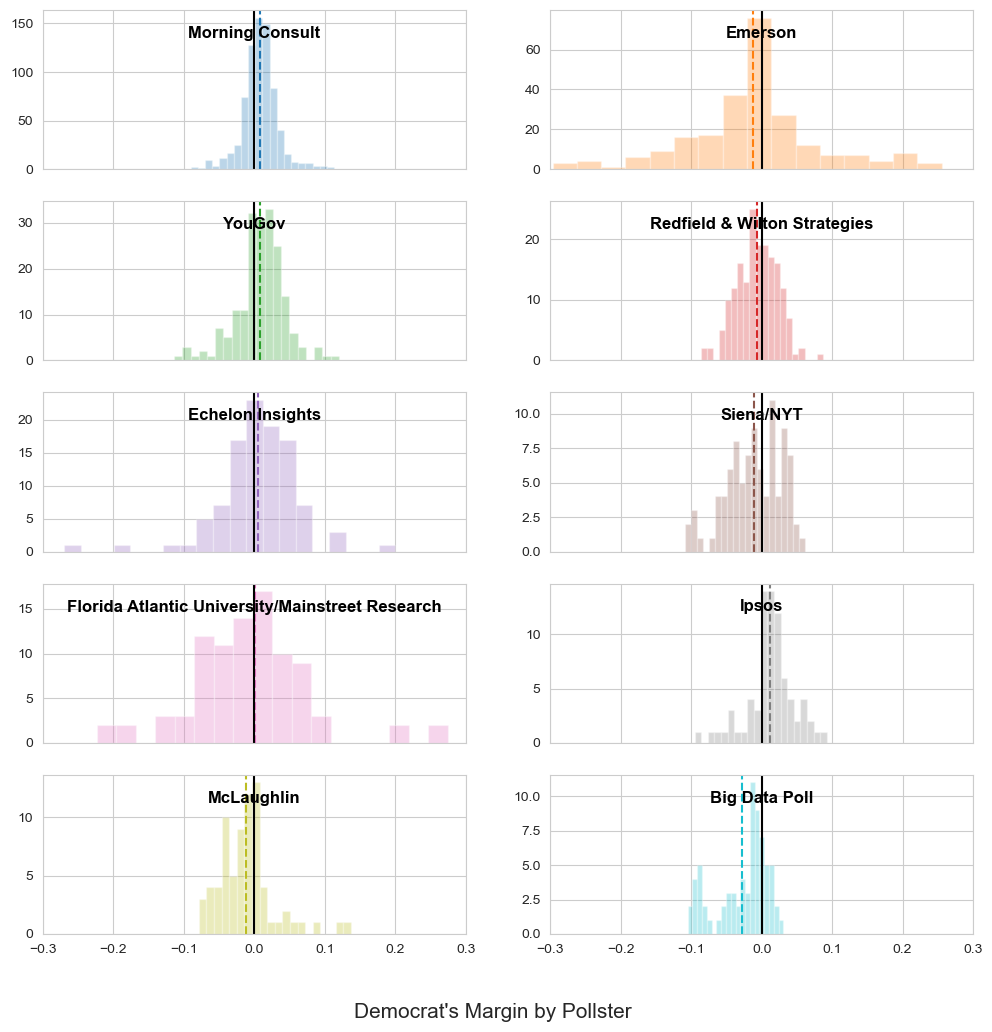

In [30]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

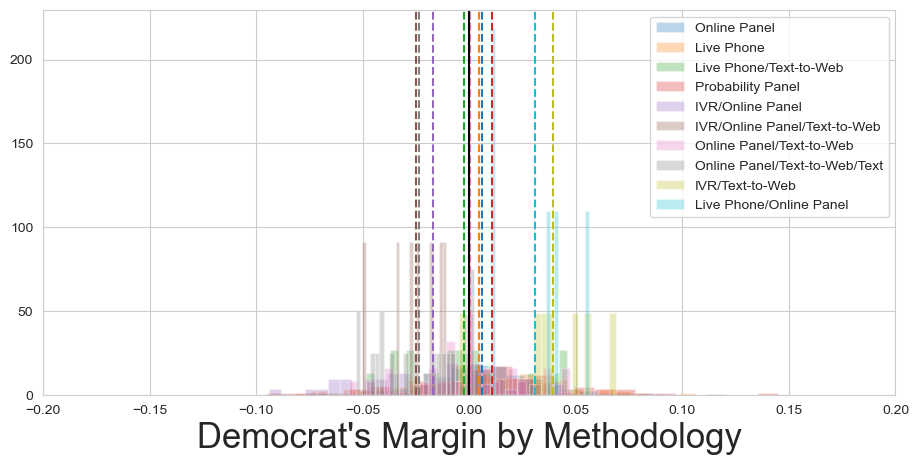

In [31]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [32]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

print(date_counts.head(10))

        date  count
0 2024-08-07     13
1 2024-08-06      1
2 2024-08-05      4
3 2024-08-03      5
4 2024-08-02      3
5 2024-08-01     15
6 2024-07-31      1
7 2024-07-30      6
8 2024-07-29      2
9 2024-07-28     16


In [33]:
df[['date','pollster',
       'methodology', 'state', 'population', 'sample_size', 'DEM', 'GOP',
       'OTHER', 'margin']].head(20)

,date,pollster,methodology,state,population,sample_size,DEM,GOP,OTHER,margin
0,2024-08-07,Siena/NYT,Live Phone,PA,rv,693.0,0.490,0.460,0.050,0.030
1,2024-08-07,Siena/NYT,Live Phone,PA,lv,693.0,0.500,0.460,0.040,0.040
2,2024-08-07,Siena/NYT,Live Phone,PA,rv,693.0,0.450,0.430,0.120,0.020
3,2024-08-07,Siena/NYT,Live Phone,PA,lv,693.0,0.460,0.440,0.100,0.020
4,2024-08-07,Quantus Polls and News,Online Panel,US,rv,1000.0,0.472,0.459,0.069,0.013
5,2024-08-07,Siena/NYT,Live Phone,MI,rv,619.0,0.450,0.480,0.070,-0.030
6,2024-08-07,Siena/NYT,Live Phone,MI,lv,619.0,0.500,0.460,0.040,0.040
7,2024-08-07,Siena/NYT,Live Phone,MI,rv,619.0,0.440,0.430,0.130,0.010
8,2024-08-07,Siena/NYT,Live Phone,MI,lv,619.0,0.480,0.430,0.090,0.050
9,2024-08-07,Siena/NYT,Live Phone,WI,rv,661.0,0.500,0.460,0.040,0.040


In [34]:
df.columns

Index(['field_date', 'poll_id', 'question_id', 'pollster_id', 'pollster',
       'methodology', 'state', 'population', 'sample_size', 'cycle',
       'election_date', 'date', 'year', 'month', 'day', 'week', 'DEM', 'GOP',
       'type', 'obs_id', 'OTHER', 'margin', 'GOP_mean', 'DEM_mean',
       'margin_mean', 'diff_GOP', 'diff_DEM', 'diff_margin'],
      dtype='object')

In [35]:
#df = df[df['date'] >= '2024-05-01'] #Only polls since one year before election
#df = df[df['date'] < '2024-07-26'] #We only have two polls for the most recent date, we don't want that to bias the long-run rws

In [36]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1,2], ['DEM','GOP','Other']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [38]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_dem = pm.Normal("polling_error_dem", 0, .1)
    polling_error_gop = pm.Normal("polling_error_gop", 0, .1)
    polling_error_oth = pm.Deterministic("polling_error_oth",-(polling_error_dem + polling_error_gop))

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_dem, polling_error_gop]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 860, 860 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 2103 seconds.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


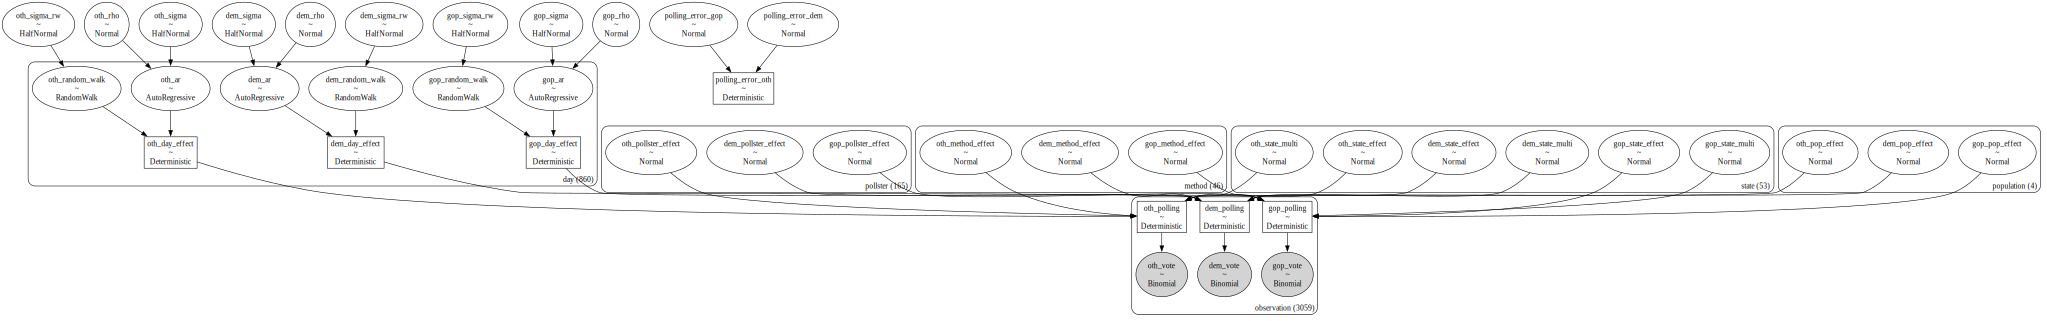

In [39]:
pm.model_to_graphviz(twoway)

In [129]:
z = pd.DataFrame()
z['state'] = idata.posterior.state
z['dem_state_multi'] = idata.posterior.dem_state_multi.mean(axis=0).mean(axis=0).values
z['dem_state_effect'] = idata.posterior.dem_state_effect.mean(axis=0).mean(axis=0).values
z['gop_state_multi'] = idata.posterior.gop_state_multi.mean(axis=0).mean(axis=0).values
z['gop_state_effect'] = idata.posterior.gop_state_effect.mean(axis=0).mean(axis=0).values
z['oth_state_multi'] = idata.posterior.oth_state_multi.mean(axis=0).mean(axis=0).values
z['oth_state_effect'] = idata.posterior.oth_state_effect.mean(axis=0).mean(axis=0).values

In [130]:
z.sort_values(by='state')

,state,dem_state_multi,dem_state_effect,gop_state_multi,gop_state_effect,oth_state_multi,oth_state_effect
0,AK,1.056666,-0.072458,0.998137,0.213559,1.334353,-0.049631
1,AL,1.033874,-0.302525,0.988431,0.403587,1.185759,-0.169979
2,AR,1.104242,-0.417868,0.985053,0.443366,1.080936,-0.086134
3,AZ,0.972814,0.060839,0.940862,-0.015572,0.861986,-0.236319
4,CA,1.586083,0.658535,1.416839,-0.514873,1.671830,0.234777
5,CO,0.609760,0.187915,1.169771,-0.236654,1.365636,0.206296
6,CT,0.946479,0.346687,1.031356,-0.308960,1.118199,-0.115054
7,FL,0.803038,-0.020101,0.947481,0.096472,0.519348,-0.587916
8,GA,0.975561,0.054785,1.048169,0.015351,0.880833,-0.278253
9,HI,0.927152,0.398559,1.009188,-0.287057,1.115773,-0.205755


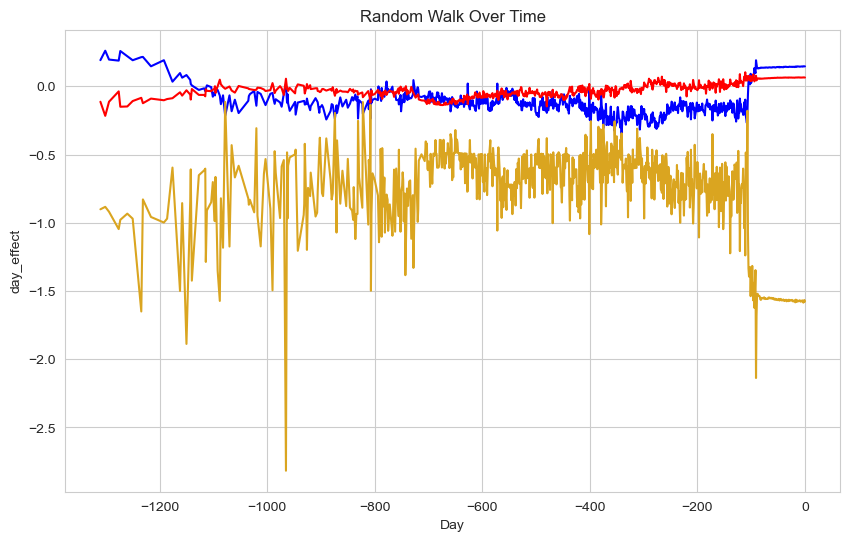

In [131]:
dem = pd.DataFrame()
dem['day'] = idata.posterior.day
dem['day_effect'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values

gop = pd.DataFrame()
gop['day'] = idata.posterior.day
gop['day_effect'] = idata.posterior.gop_day_effect.mean(axis=0).mean(axis=0).values

oth = pd.DataFrame()
oth['day'] = idata.posterior.day
oth['day_effect'] = idata.posterior.oth_day_effect.mean(axis=0).mean(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(dem['day'], dem['day_effect'], color='blue', label='Democrats', linestyle='-')
plt.plot(gop['day'], gop['day_effect'], color='red', label='Republicans', linestyle='-')
plt.plot(oth['day'], oth['day_effect'], color='goldenrod', label='Other', linestyle='-')
plt.xlabel('Day')
plt.ylabel('day_effect')
plt.title('Random Walk Over Time')
plt.grid(True)
plt.show()

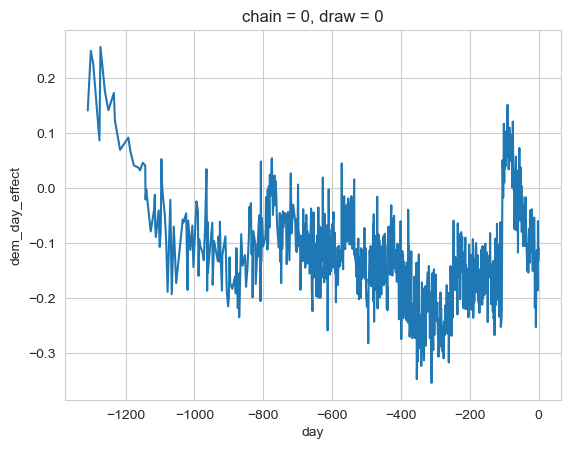

In [132]:
idata.posterior.dem_day_effect.sel(chain=0, draw=0).plot()

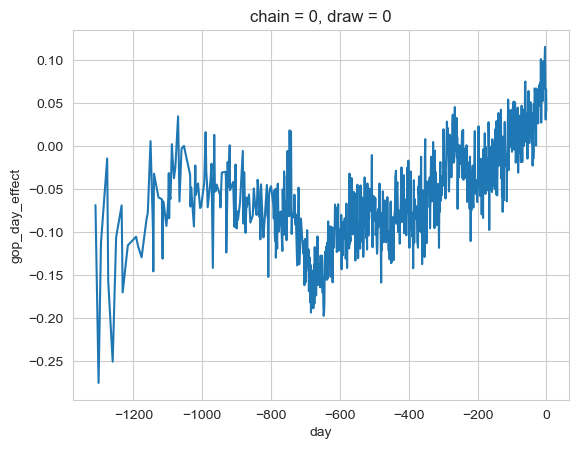

In [133]:
idata.posterior.gop_day_effect.sel(chain=0, draw=0).plot()

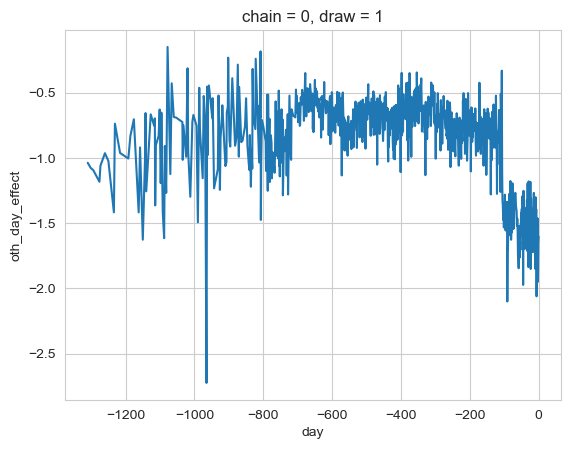

In [134]:
idata.posterior.oth_day_effect.sel(chain=0, draw=1).plot()

In [135]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [243]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Quinnipiac") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Suffolk") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="U. Massachusetts - Lowell")
    ).values / 10
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'IVR/Live Phone/Text/Online Panel/Email', drop=True).mean(axis=2)
    )/4
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] + interim[f"polling_error_{party}"]

In [320]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-86]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            # Calculate the results and store them in the dictionary
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
            ).to_numpy()

        # Adjust the 'oth' results and sum the total
        day_results[f"{state}_dem"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_gop"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_oth"] /= 2

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.mean()
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 860/860 [01:09<00:00, 12.36it/s]


<Axes: >

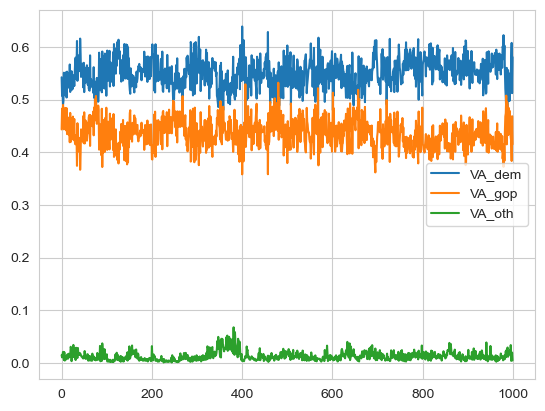

In [321]:
df_results[['VA_dem','VA_gop','VA_oth']].plot()

In [322]:
df.date

0      2024-08-07
1      2024-08-07
2      2024-08-07
3      2024-08-07
4      2024-08-07
          ...    
3054   2021-05-12
3055   2021-05-09
3056   2021-04-21
3057   2021-04-14
3058   2021-04-05
Name: date, Length: 3059, dtype: datetime64[ns]

In [323]:
pd.date_range(start=df.date.min(), end='2024-11-05')

DatetimeIndex(['2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
               '2021-04-13', '2021-04-14',
               ...
               '2024-10-27', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01', '2024-11-02', '2024-11-03',
               '2024-11-04', '2024-11-05'],
              dtype='datetime64[ns]', length=1311, freq='D')

In [324]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [325]:
min(df_day_mean.index)

-1310

In [326]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/4093770033.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/4093770033.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

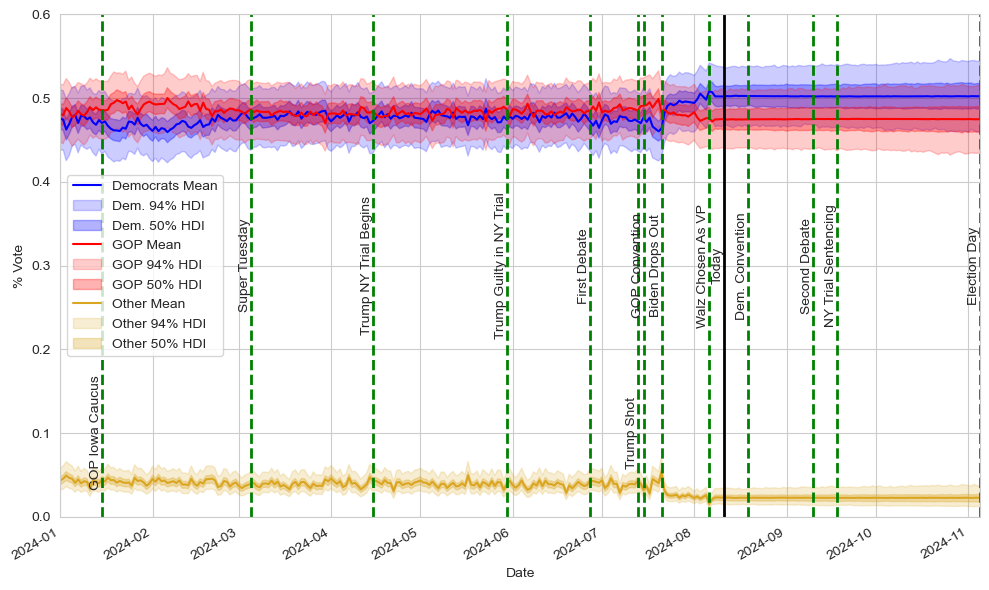

In [327]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='Other 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='Other 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]
oth_votes = df.set_index('date').query(f"state == '{graph_state}'")["OTHER"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=dt.datetime(2024, 7, 13), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 7, 13), 0.1, "Trump Shot", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
ax.axvline(x=dt.datetime(2024, 1, 15), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 1, 15), 0.1, "GOP Iowa Caucus", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.3, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/817445249.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/817445249.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, la

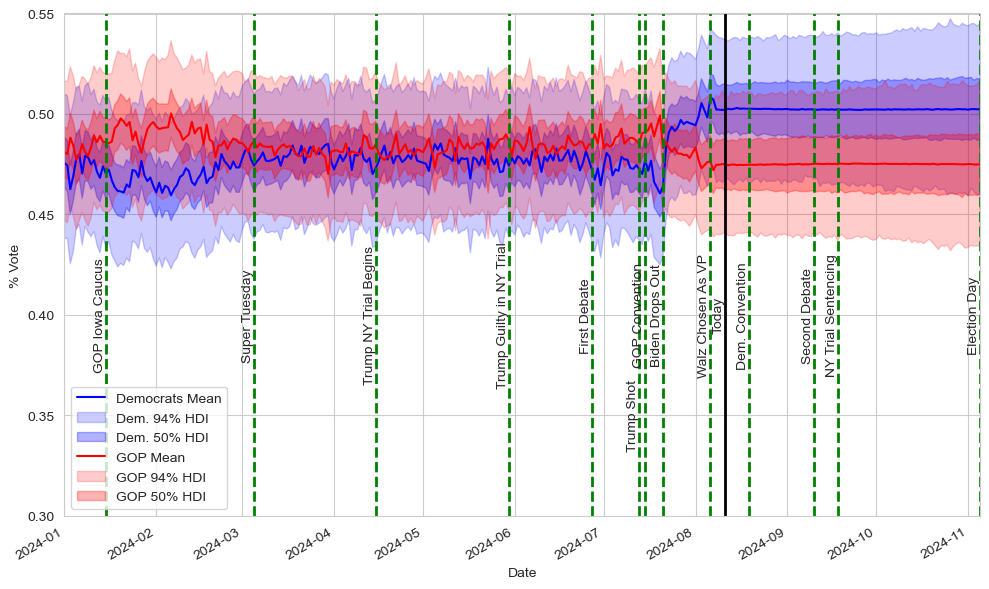

In [328]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')


dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0.3,.55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend(loc='lower left', bbox_to_anchor=(0, 0))
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), "GOP Iowa Caucus"),
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.4, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=dt.datetime(2024, 7, 13), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 7, 13), 0.35, "Trump Shot", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.4, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('this_year_zoom.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/1933150396.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/1933150396.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

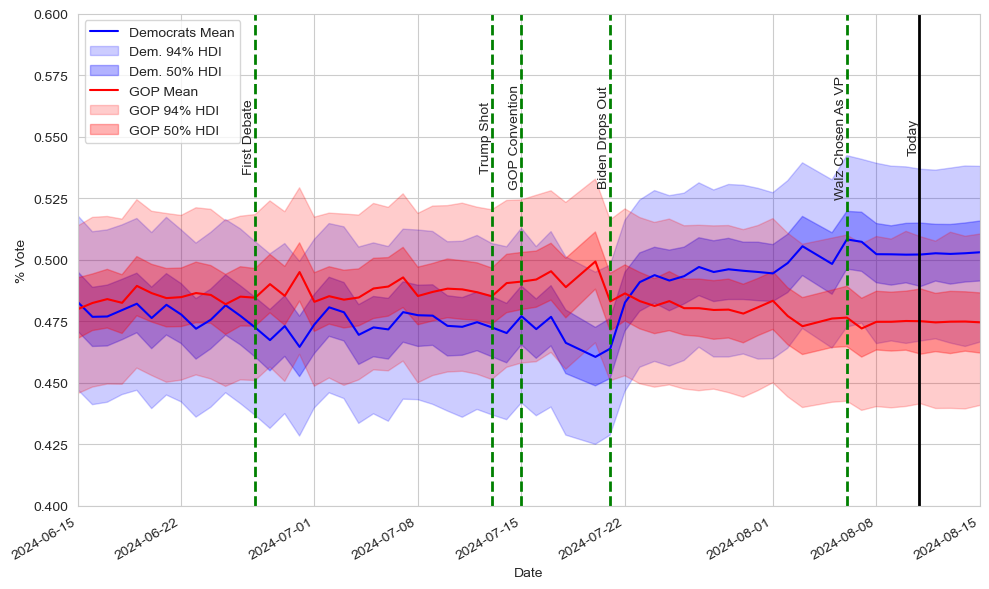

In [329]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

# Set limits and labels
ax.set_ylim(.4,.6)
ax.set_xlim(dt.datetime(2024, 6, 15), dt.datetime(2024, 8, 15))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            #(dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            #(dt.datetime(2024, 3,  5), 'Super Tuesday'),
            #(dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            #(dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            #(dt.datetime(2024, 8, 19), 'Dem. Convention'),
            #(dt.datetime(2024, 9, 10), 'Second Debate'),
            #(dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            #(dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.55, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=dt.datetime(2024, 7, 13), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 7, 13), 0.55, "Trump Shot", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.55, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('past_two_months.png')

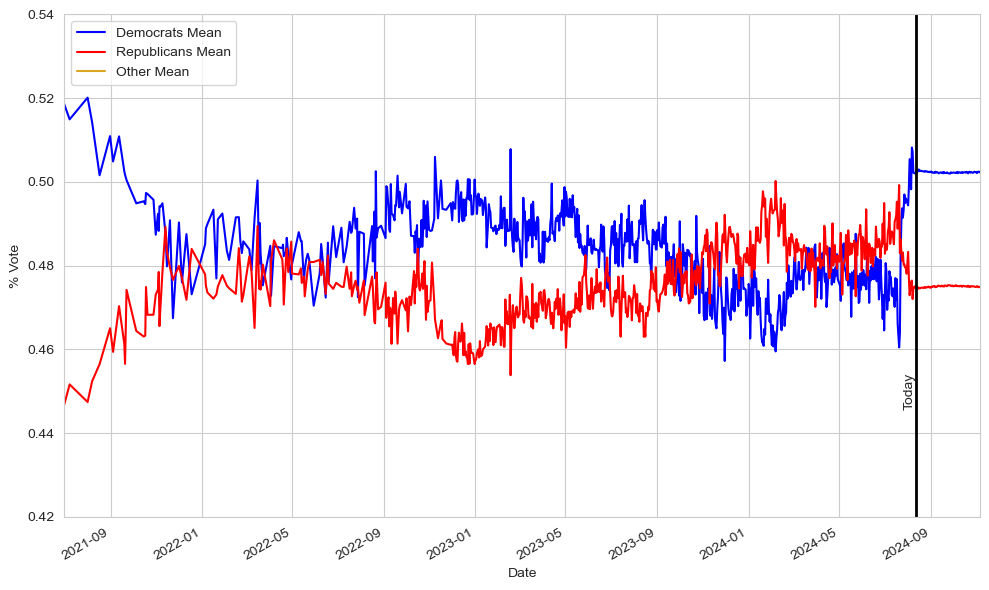

In [330]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0.42,0.54)
ax.set_xlim(dt.datetime(2021, 7, 1), dt.datetime(2024, 11, 5) #datetime.datetime.today()
           )
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            #(dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            #(dt.datetime(2024, 3,  5), 'Super Tuesday'),
            #(dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            #(dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            #(dt.datetime(2024, 6, 27), 'First Debate'),
            #(dt.datetime(2024, 7, 15), 'GOP Convention'),
            #(dt.datetime(2024, 8, 19), 'Dem. Convention'),
            #(dt.datetime(2024, 9, 10), 'Second Debate'),
            #(dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            #(dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.42, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
#ax.axvline(x=datetime.datetime.today(), color='green', linestyle='-', linewidth=2)
#plt.text(dt.datetime(2024, 7, 13), 0.45, "Trump Assassination Attempt", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.45, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('past_three_years.png')

In [331]:
# List of states to loop over
state_loop = ['TX', 'CA', 'MN', 'MI', 'FL', 'GA', 'US','WI','PA','AZ','NV','NC', 'NY']

# Loop over each state
for state in state_loop:
    graph_state = state
    
    # Create a new figure for each state
    plt.figure(figsize=(10, 6))
    
    # Define the bin edges, ensuring that they align perfectly
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    # Plot the histogram using the pre-defined bins
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    # Get patches from the Axes
    for patch in ax.patches:
        # Get x midpoint of bar
        x = patch.get_x() + 0.5 * patch.get_width()
        
        # Set bar color based on x
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    # Add titles and labels
    plt.title(f'2024 Today - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'2way_enight_{state.lower()}.png')
    
    # Close the figure to avoid overlapping
    plt.close()


In [332]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [333]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

7       DE
30    NE-1
32    NE-3
56      DC
Name: state_code, dtype: object

In [334]:
#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'NE-2', 'DC']] = 'dem'

#df_winner[['NE-1', 'NE-3']] = 'gop'
#df_winner[['DE','DC']] = 'dem'

df_winner['DE'] = df_winner['IL']
df_winner['NE-1'] = df_winner['KS']
df_winner['NE-3'] = df_winner['WY']
df_winner['DC'] = df_winner['VT']

state_order = df_state['state_code'].to_list

In [335]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_80505/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [336]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']

In [337]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win without Popular Vote")
print("-------------------------------------")
print(" Democrats:   " + str(round(pct_dem_wo_pop,2)))
print(" Republicans: " + str(round(pct_gop_wo_pop,2)))
print(" Total:       " + str(round(pct_dem_wo_pop+pct_gop_wo_pop,2)))
print()
print("Popular Vote Estimate")
print("---------------------")
print(" Democrats:   " + str(round(df_dem.US.mean()*100,2)))
print(" Republicans: " + str(round(df_gop.US.mean()*100,2)))
print(" Other:       " + str(round(df_oth.US.mean()*100,2)))
print(" Margin:      " + str(round(df_dem.US.mean()*100 - df_gop.US.mean()*100,2)))

% Chance of a Win without Popular Vote
-------------------------------------
 Democrats:   1.0
 Republicans: 1.8
 Total:       2.8

Popular Vote Estimate
---------------------
 Democrats:   50.24
 Republicans: 47.49
 Other:       2.26
 Margin:      2.75


In [338]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(73.3, 0.7000000000000001, 26.0)

In [339]:
df_ec.max()

dem        524
gop        452
dem_pop      1
gop_pop      1
dtype: int64

In [340]:
df_ec.min()

dem        86
gop        14
dem_pop     0
gop_pop     0
dtype: int64

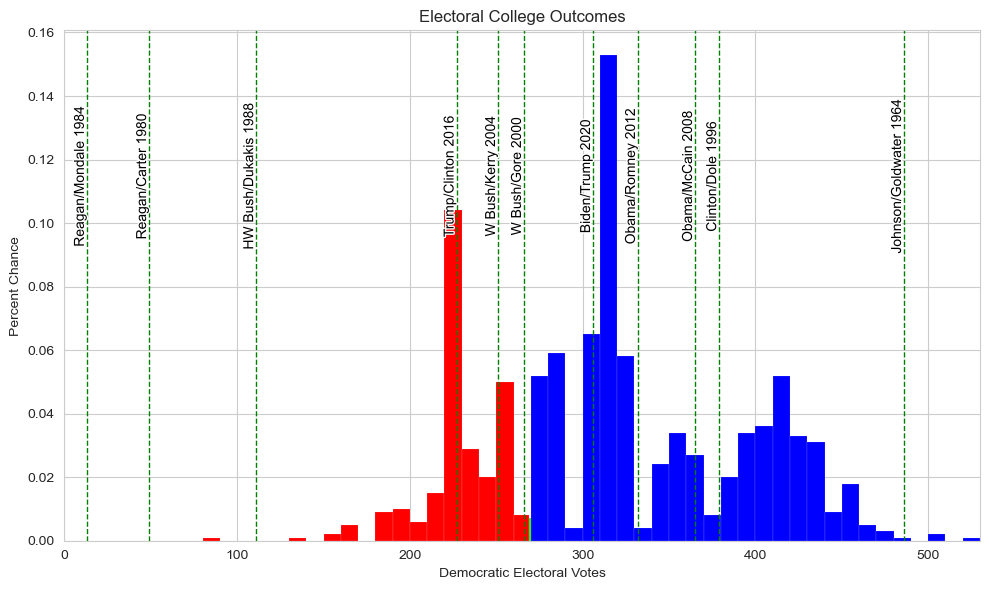

In [341]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 269, 10)) + [269] + list(range(270, 540, 10))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])
plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [342]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]
    df_oth[state] = df_results[f"{state}_oth"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['oth'] = df_oth.mean()
df_mean['margin'] = df_margin.mean()

In [343]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [344]:
df_win_pct.sort_values('dem')

,dem,gop
NE-3,0.000,1.000
OK,0.000,1.000
WY,0.000,1.000
WV,0.001,0.999
ND,0.002,0.998
AR,0.002,0.998
KY,0.003,0.997
AL,0.005,0.995
ID,0.007,0.993
SD,0.007,0.993


In [345]:
df_mean.sort_values('margin')

,dem,gop,margin,oth
WY,0.329927,0.653313,-0.323385,0.016760
OK,0.375328,0.601261,-0.225934,0.023411
ND,0.380728,0.585404,-0.204676,0.033868
WV,0.390902,0.586302,-0.195400,0.022796
AR,0.397220,0.585293,-0.188073,0.017487
KY,0.398964,0.581623,-0.182658,0.019413
ID,0.409067,0.570851,-0.161784,0.020082
AL,0.416037,0.570127,-0.154090,0.013836
SD,0.410777,0.564848,-0.154070,0.024375
UT,0.405751,0.551698,-0.145947,0.042550


In [346]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).mean()
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin = pd.merge(df_margin,df_state[['state_code','electoral_2024']], left_index=True, right_on='state_code')

In [347]:
df_margin

,hdi_03,hdi_25,hdi_mean,hdi_75,hdi_97,state_code,electoral_2024
43,-0.057092,-0.002728,0.026946,0.057557,0.111819,PA,19
28,-0.054157,-0.000411,0.027527,0.057535,0.111407,US,0
23,-0.044859,0.009643,0.039269,0.070924,0.121689,MI,15
54,-0.049075,0.012512,0.044139,0.077724,0.133551,WI,10
27,-0.210752,-0.150395,-0.113998,-0.077272,-0.009835,MT,4
2,-0.070503,-0.007863,0.024959,0.057366,0.117011,AZ,11
8,-0.111717,-0.056303,-0.025247,0.006238,0.059979,FL,30
9,-0.077822,-0.019576,0.014529,0.049710,0.107633,GA,16
24,-0.003424,0.057368,0.091213,0.126481,0.183228,MN,10
33,-0.070305,-0.006515,0.028518,0.063595,0.121890,NV,6


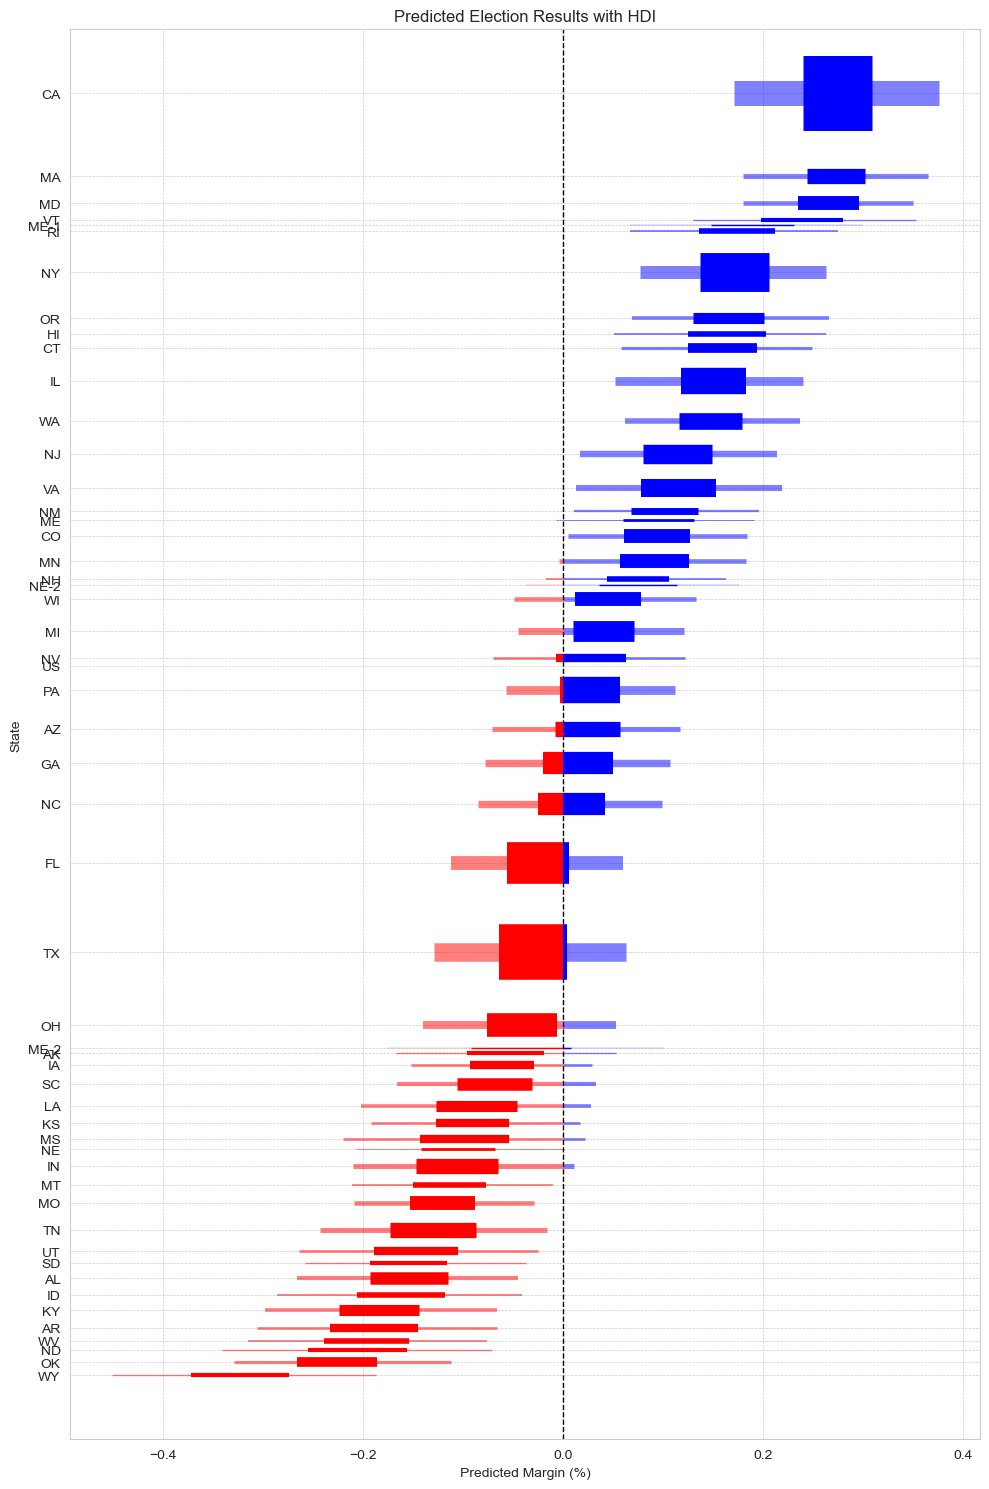

In [348]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 15))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

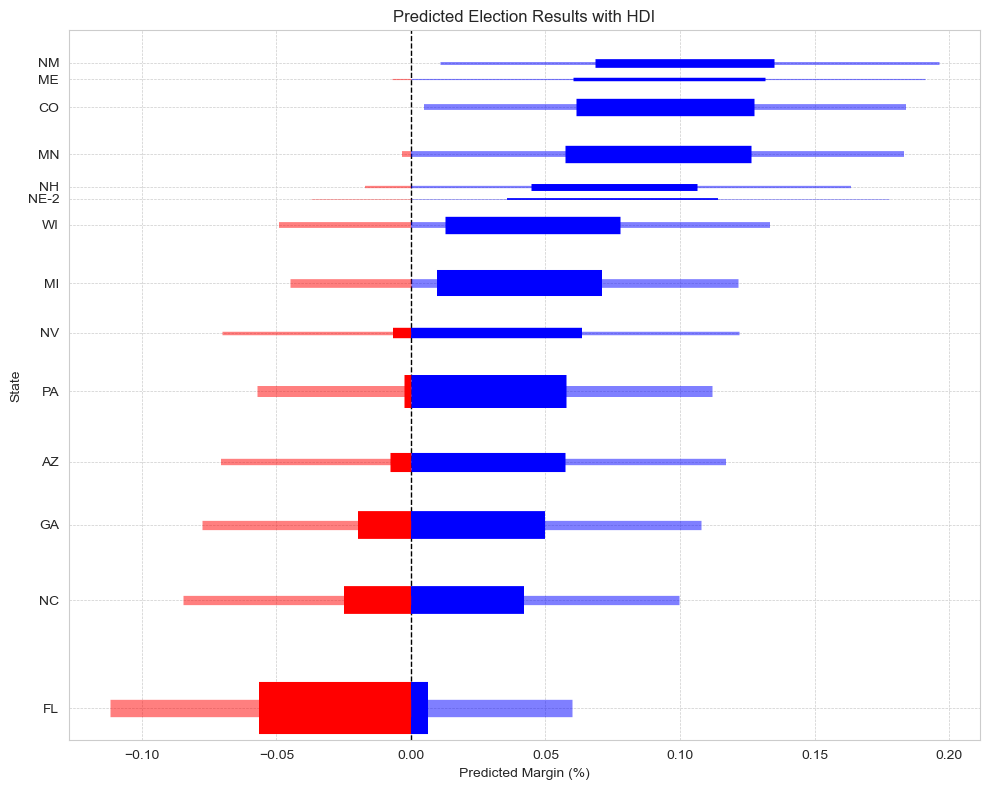

In [349]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('FL','NC','GA','AZ','PA','NV','MI','WI','NE-2','NH','MN','ME','CO','NM')").sort_values(by='hdi_mean')
scale_factor = 1.25

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 8))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')